In [1]:
import numpy as np
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt 
from scipy.integrate import quad
from scipy.integrate import quad_vec
import scipy
print(scipy.version.version)
from matplotlib.patches import Rectangle

import dask
from dask import delayed


1.9.3


4.7e-08 This is the pulse energy in Joules
11.044999999999998 Ppeakc, the peak power for a gaussian pulse
411744.05330499227 Ec
32789244244.112503 angular rabi frequency of the control field
3.4470712128424914e+18 number density


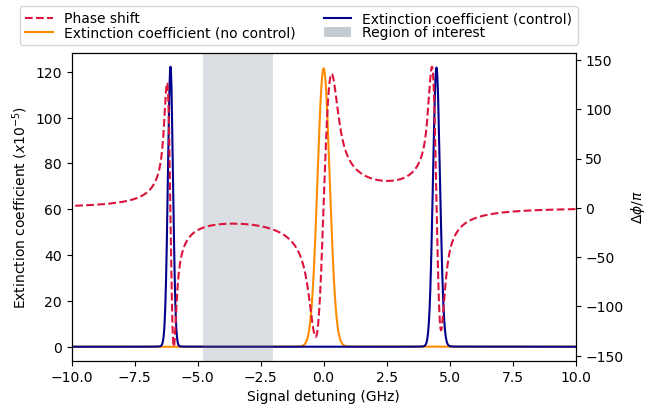

In [4]:
#For Rb87 isotopically pure cells, looking at the upper Rb87 ground state with only F = 2 state and no other states 

#Constants
e = 1.602*10**-19 #elementary charge in coulombs .
a0 = 5.29*10**-11 #bohr radius in meters .
c = 2.998*10**8 #speed of light in vacuum .
epsilon0 = 8.854*10**-12 #Vacuum permittivity .
u0 = 1.2566*10**-6 #Vacuum permeability .
kb = 1.381*10**-23 #Boltzmann's constant .
vs = 1 #polarisation vector, assume that d12.vs = d12 
vc = 1 #polarisation vector, assume that d23.vc = d23 
hbar = 1.0546*10**-34 #in SI units .

#Peak power gaussian pulse (control)
tFWHM = 4000*10**-12 #our 1ns base width pulses look around ~600ns FWHM on the 1GHz scope
RepRate = 1*10**6 #3 MHz repetition rate
AveragePower = 47*10**-3# average power of control 
Epc = AveragePower/RepRate #energy of control pulses 
Ppeakc = 0.94*Epc/tFWHM 
print(Epc, 'This is the pulse energy in Joules')
print(Ppeakc, 'Ppeakc, the peak power for a gaussian pulse')


w0 = 125*10**-6 #if we use 2.00mm collimating lens with 100mm focusing lenses then we can get a beam waist of around 125um
#w0 = 450*10**-6 #beam waist (radius), using the 4.51 mm collimating lenses

#Ipeakc = 2*Ppeakc/(np.pi*w0**2)  #Peak intensity. The peak power I0 = 2*Iavg Assume uniform in x and y, with time dependence on power/intensity Ppeak/A  https://courses.lumenlearning.com/physics/chapter/24-4-energy-in-electromagnetic-waves/
Ipeakc = Ppeakc/(np.pi*w0**2)  #Average intensity. The peak power I0 = 2*Iavg Assume uniform in x and y, with time dependence on power/intensity Ppeak/A  https://courses.lumenlearning.com/physics/chapter/24-4-energy-in-electromagnetic-waves/
Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
Ec = Epeakc

#Relative positions of the ground hyperfine states, relative to the lowest energy Rb87 ground state 
TopRb87 = 0 #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb87 state
BottomRb87 = -4.271-2.563 #detuning from the bottom Rb87 hyperfine state (GHz) for the bottom Rb87 state
TopRb85 = 4.271+1.264 -(4.271+2.563) #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb85 state
BottomRb85 = 4.271-1.770 -(4.271+2.563) #detuning from the bottom Rb87 hyperfine state (GHz) for the bottom Rb85 state

#More constants and calculated values 
f = c/(7800.268*10**-10) #frequency of signal 
w21 = 2*np.pi*(c/(7800.268*10**-10)) #angular frequency of transition from atomic ground state to intermediate
w32 = 2*np.pi*(c/(7757.6507*10**-10)) #angular frequency of transition from atomic intermediate state to excited state 

#swapping top and bottom Rb87 

DeltaSTopRb87 = np.linspace(-2*np.pi*10*10**9, 2*np.pi*10*10**9, 2000)  #the shift is negative, as the shift is too a shorter frequency than w21, delta = w21 - ws, if w21 is the transition from the bottom energy level, then a negative delta is a larger frequency, and a positive detuning is for a smaller frequency  
DeltaSBottomRb87 = -2*np.pi*BottomRb87*10**9 + DeltaSTopRb87 #np.linspace(-2*np.pi*10*10**9, 2*np.pi*15.0*10**9, 1000) #= w21 - ws what units and sign? Check definition in notes 
DeltaSTopRb85 = -2*np.pi*TopRb85*10**9 + DeltaSTopRb87
DeltaSBottomRb85 = -2*np.pi*BottomRb85*10**9 + DeltaSTopRb87

DeltaCTopRb87 = 2*np.pi*(1.6)*10**9 
#positive value of detuning in the bracket for positive control detuning
#i.e. blue detuned, longer frequency control to give two photon resonance
#at a shorter frequency

DeltaCBottomRb87  = DeltaCTopRb87 ##= w32 - wc what units and sign? Check definition in notes 
DeltaCTopRb85 =  DeltaCTopRb87 #
DeltaCBottomRb85 = DeltaCTopRb87 #
#The control detuning should the same for each Rb ground state as it is the frequency between the middle and upper states
#and not between the ground and intermediate states! 

wsBottomRb87 = w21 - DeltaSBottomRb87 #angular frequency of signal field 
wsTopRb87 = w21 - DeltaSTopRb87 #angular frequency of signal field 
wsTopRb85 = w21 - DeltaSTopRb85 #angular frequency of signal field 
wsBottomRb85 = w21 - DeltaSBottomRb85 #angular frequency of signal field 

wcBottomRb87 = w32 - DeltaCBottomRb87 #angular frequency of control field 
wcTopRb87 = w32 - DeltaCTopRb87 #angular frequency of control field 
wcTopRb85 = w32 - DeltaCTopRb85 #angular frequency of control field 
wcBottomRb85 = w32 - DeltaCBottomRb85 #angular frequency of control field 
ksBottomRb87 = ks = wsBottomRb87/c #=omega/c
ksTopRb87 = wsTopRb87/c
ksTopRb85 = wsTopRb85/c
ksBottomRb85 = wsBottomRb85/c

kcBottomRb87 = wcBottomRb87/c #=omega/c
kcTopRb87 = wcTopRb87/c #=omega/c
kcTopRb85 = wcTopRb85/c #=omega/c
kcBottomRb85 = wcBottomRb85/c #=omega/c
tau2 = 26.24*10**-9 #lifetime of 5P state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
tau3 = 238.5*10**-9 #lifetime of 5D state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
gamma2 = 1/tau2
gamma3 = 1/tau3
d12 = 4.227*e*a0 #Dipole matrix element for 5S1/2 to 5P3/2 value from Engineering photon-photon interaction within rubidium filled waveguides
d23 = 0.991*e*a0 #Dipole matrix element for 5P3/2 to 5D5/2 value from Engineering photon-photon interaction within rubidium filled waveguides
kappa = d12*vs/hbar #similar to the rabi frequency of the signal field, but divided by Es 
Omega = d23*vc*Ec/hbar #rabi frequency of the control field

#all the above constants seem to be correct

print(Ec,'Ec')

print(Omega, 'angular rabi frequency of the control field')

#lambda0 = lambda ws: c/(ws/(2*np.pi)) #lambda = c/f, f = w/2*pi

lambda0 = c/(w21/(2*np.pi)) #assuming a constant lambda0, we may need to change this so that lambda0 changes as we scan detuning 

L = 70*10**-3 #length of vapour cell, 7cm (70mm)

#Calculating the number density for Rb87
T = (95+273.15) #Temperature in Kelvin from Daniel Steck's Rb87 data
#p87 = 1*4*10**-6*133.322 #66.7*10**-7 #Pressure in Pa from Daniel Steck's Rb87 data, assuming only natural abundance of Rb87
Pv = 10**(15.88253 - 4529.635/T + 0.00058663*T - 2.99138*np.log10(T))  #vapour pressure in Torr
p87 = Pv*133.322 #Pressure in Pa from Daniel Steck's Rb87 data, assuming only natural abundance of Rb87

#nd87 = p87/(kb*T) #(atoms per unit volume - relates to vapour pressure of Rb - #probably check steck and choose an isotope )

nd87 =  p87/(kb*T) #(atoms per unit volume - relates to vapour pressure of Rb - #probably check steck and choose an isotope )

#nd87 = 2.95*10**18 #number density at 92.6C estimated from equation in Steck
mw = 86.909 #molecular weightmass of Rb atom, either 86.909*u or 86.909 grams per mole 
u = 1.661*10**-27 #unified atomic mass unit (dalton)
m = u*mw #mass of a single atom of Rb87 (can either divide molecular weight by Avogadro's number or multiply by universal mass unit to get the weight of an atom. Universal mass unit will get an answer in kg, Avogadro's will get an answer in grams)

#4*10**-6 Torr at 52 degrees C steck data

#looks like everything above this is correct 

ARb87 = -nd87*d12*kappa/epsilon0 

#Defining functions, solving the integration 

DeltaS = DeltaSTopRb87 

#Weightings by the relative populations of the hyperfine states

Rb87zeemanWeightingF2 = 5/8
Rb87zeemanWeightingF1 = 0
Rb85zeemanWeightingF3 = 0
Rb85zeemanWeightingF2 = 0

#maxwell boltzmann distribution in 1D is correct 

p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function for doppler
#tauBottomRb87 = lambda v: 1j*gamma2/2 -DeltaS + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-DeltaS)+v*(ks-kcBottomRb87)))
tauBottomRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*BottomRb87*10**9) + v*ksBottomRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-(DeltaS - 2*np.pi*BottomRb87*10**9))+v*(ksBottomRb87-kcBottomRb87)))
tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*TopRb87*10**9) + v*ksTopRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCTopRb87-(DeltaS - 2*np.pi*TopRb87*10**9))+v*(ksTopRb87-kcTopRb87)))

fReBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).real   #A*(row/tau)
fImBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).imag   #A*(row/tau)

fReTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
fImTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)


ChiReBottomRb87 = quad_vec(fReBottomRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
ChiImBottomRb87 = quad_vec(fImBottomRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

ChiReTopRb87 = quad_vec(fReTopRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
ChiImTopRb87 = quad_vec(fImTopRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

ChiTotalControl = (ChiReBottomRb87 + ChiReTopRb87) + 1j*(ChiImBottomRb87 +ChiImTopRb87) #complex susceptibility 
nComplexControl = (1+ChiTotalControl)**0.5 #the complex refractive index with the control field on 

refractiveIndexControl = nComplexControl.real
ExtinctionCoefficientControl = nComplexControl.imag

Ec = 0
Omega = d23*vc*Ec/hbar #rabi frequency of the control field

p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function 
#tauBottomRb87 = lambda v: 1j*gamma2/2 -DeltaS + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-DeltaS)+v*(ks-kcBottomRb87)))
tauBottomRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*BottomRb87*10**9) + v*ksBottomRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-(DeltaS - 2*np.pi*BottomRb87*10**9))+v*(ksBottomRb87-kcBottomRb87)))
tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*TopRb87*10**9) + v*ksTopRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCTopRb87-(DeltaS - 2*np.pi*TopRb87*10**9))+v*(ksTopRb87-kcTopRb87)))

#the tau equations look correct

fReBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).real   #A*(row/tau)
fImBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).imag   #A*(row/tau)

fReTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
fImTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)

ChiReBottomRb87 = quad_vec(fReBottomRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
ChiImBottomRb87 = quad_vec(fImBottomRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

ChiReTopRb87 = quad_vec(fReTopRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
ChiImTopRb87 = quad_vec(fImTopRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

ChiTotalNoControl = (ChiReBottomRb87 + ChiReTopRb87) + 1j*(ChiImBottomRb87 +ChiImTopRb87) #complex susceptibility 
nComplexNoControl = (1+ChiTotalNoControl)**0.5 #the complex refractive index with the control field on 

refractiveIndexNoControl = nComplexNoControl.real
ExtinctionCoefficientNoControl = nComplexNoControl.imag

DeltaPhi = (refractiveIndexControl - refractiveIndexNoControl)*(2*np.pi*L/lambda0)

fig, ax1 = plt.subplots()
#plt.figure(figsize=(8,5), dpi=300)
ax2 = ax1.twinx()

PhaseShift, = ax2.plot(-DeltaSTopRb87*10**-9/(2*np.pi), DeltaPhi/(np.pi), '--', color='crimson', label='Relative phase change')
TNoControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), ExtinctionCoefficientNoControl*10**5 , color='darkorange', label='Extinction coefficient (no control field)')
tControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), ExtinctionCoefficientControl*10**5 , color='darkblue', label='Extinction coefficient (control field)')

#plt.axvline(x=-BottomRb87) #assume that we are on resonance with the bottom Rb87 state at -4.271GHz detuning 
#plt.axvline(x=-TopRb87)
#plt.axvline(x=-TopRb85)
#plt.axvline(x=-BottomRb85)

ax1.set_xlabel('Signal detuning (GHz)')
ax2.set_ylabel('$\Delta \phi$/$\pi$')
ax1.set_ylabel('Extinction coefficient ($x10^{-5}$)')
ax1.set_xlim(-10, 10)

#ax1.set_ylim(-20, 20)
#ax1.set_xlim(-5, 7.5)

rect = Rectangle((0, 0), 1, 1, fc="slategrey", alpha=0.4)

plt.figlegend([PhaseShift, TNoControl,tControl, rect], ['Phase shift', 'Extinction coefficient (no control)', 'Extinction coefficient (control)', 'Region of interest'], loc = (0.03, 0.89), ncol=2, labelspacing=0.)

a = -4.8
b = -2

plt.axvspan(a, b, color='slategrey', alpha=0.25, lw=0)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(4) #sets the size of the subplot figure
fig.set_figwidth(6.5)

fig.subplots_adjust(hspace=0)

plt.savefig('Relative phase shift and extinction coefficient vapour cell 1.6 GHz control detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns pulse.png', dpi=400, bbox_inches='tight')
plt.savefig('Relative phase shift and extinction coefficient vapour cell 1.6 GHz control detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns pulse.pdf', dpi=400, bbox_inches='tight')

print(nd87, 'number density')

11.044999999999998 Ppeakc, the peak power for a gaussian pulse


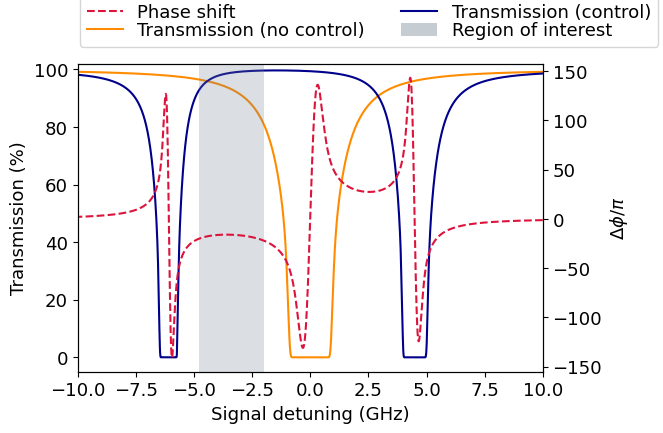

In [5]:
#Plotting the transmission and phase shift for paper
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 13})

fig, ax1 = plt.subplots()
#plt.figure(figsize=(8,5), dpi=300)
ax2 = ax1.twinx()

f = c/(7800.268*10**-10) #frequency of signal 

AbsorptionCoefficientNoControl = 4*np.pi*f*ExtinctionCoefficientNoControl/c #absorption coefficient with no control field
AbsorptionCoefficientControl = 4*np.pi*f*ExtinctionCoefficientControl/c #absorption coefficient with control field

RatioOfOutputToInputPowerNoControl = np.exp(-AbsorptionCoefficientNoControl*L)
RatioOfOutputToInputPowerControl = np.exp(-AbsorptionCoefficientControl*L)

PhaseShift, = ax2.plot(-DeltaSTopRb87*10**-9/(2*np.pi), DeltaPhi/(np.pi), '--',  c='crimson', label='Relative phase change')
TNoControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerNoControl*100, color='darkorange', label='Transmission (%, No control field)')
tControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerControl*100, c='darkblue', label='Transmission (%, with control field)')

ax1.set_xlabel('Signal detuning (GHz)')
ax2.set_ylabel('$\Delta \phi$/$\pi$')
ax1.set_ylabel('Transmission (%)')

ax1.set_ylim(-5, 102)
#ax1.set_ylim(-50, -10)
ax1.set_xlim(-10, 10)

rect = Rectangle((0, 0), 1, 1, fc="slategrey", alpha=0.4)

plt.figlegend([PhaseShift, TNoControl,tControl, rect], ['Phase shift', 'Transmission (no control)', 'Transmission (control)', 'Region of interest'], loc = (0.12, 0.89), ncol=2, labelspacing=0.)

a = -4.8
b = -2

plt.axvspan(a, b, color='slategrey', alpha=0.25, lw=0)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(4) #sets the size of the subplot figure
fig.set_figwidth(6)

fig.subplots_adjust(hspace=0)

plt.savefig('phase shift transmission 1.6 GHz detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns single hyperfine.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('phase shift transmission 1.6 GHz detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns single hyperfine.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

SignalDetuningExport = -DeltaSTopRb87*10**-9/(2*np.pi)
DeltaPhiExport = DeltaPhi/(np.pi)
TransmissionExportNoControl = RatioOfOutputToInputPowerNoControl
TransmissionExportControl = RatioOfOutputToInputPowerControl

import pandas as pd

SignalDetuningExportDF = pd.DataFrame({"SignalDetuningGHz": SignalDetuningExport})  
DeltaPhiExportDF = pd.DataFrame({"DeltaPhi/pi": DeltaPhiExport})
TransmissionExportNoControlDF = pd.DataFrame({"TransmissionExportNoControl": TransmissionExportNoControl})
TransmissionExportControlDF = pd.DataFrame({"TransmissionExportControl": TransmissionExportControl})


TheoryResultsOutput = pd.concat([SignalDetuningExportDF,DeltaPhiExportDF,TransmissionExportNoControlDF,TransmissionExportControlDF], axis=1)
    
TheoryResultsOutput.to_csv('CW theory results at approx experimental settings.csv', encoding='utf-8')   

print(Ppeakc, 'Ppeakc, the peak power for a gaussian pulse')

0.987403944205052 RatioOfOutputToInputPowerControlArray top plot at -2 GHz
0.9356924416729892 RatioOfOutputToInputPowerNoControlArray top plot at -2 GHz
-16.042166014098278 DeltaPhiArray top plot at -2 GHz


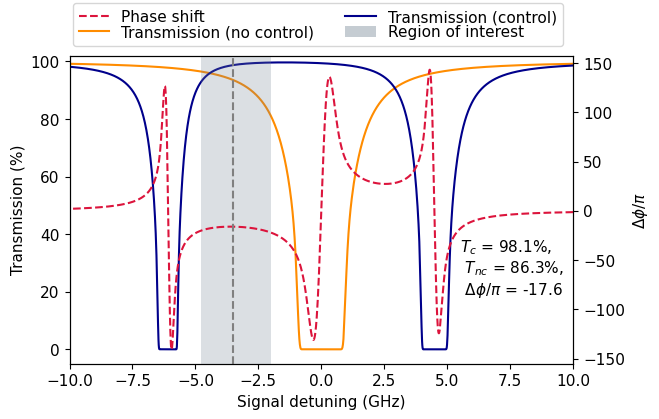

In [6]:
#Plotting the transmission and phase shift for thesis
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 11})

fig, ax1 = plt.subplots()
#plt.figure(figsize=(8,5), dpi=300)
ax2 = ax1.twinx()

f = c/(7800.268*10**-10) #frequency of signal 

AbsorptionCoefficientNoControl = 4*np.pi*f*ExtinctionCoefficientNoControl/c #absorption coefficient with no control field
AbsorptionCoefficientControl = 4*np.pi*f*ExtinctionCoefficientControl/c #absorption coefficient with control field

RatioOfOutputToInputPowerNoControl = np.exp(-AbsorptionCoefficientNoControl*L)
RatioOfOutputToInputPowerControl = np.exp(-AbsorptionCoefficientControl*L)

PhaseShift, = ax2.plot(-DeltaSTopRb87*10**-9/(2*np.pi), DeltaPhi/(np.pi), '--',  c='crimson', label='Relative phase change')
TNoControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerNoControl*100, color='darkorange', label='Transmission (%, No control field)')
tControl, = ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerControl*100, c='darkblue', label='Transmission (%, with control field)')

ax1.set_xlabel('Signal detuning (GHz)')
ax2.set_ylabel('$\Delta \phi$/$\pi$')
ax1.set_ylabel('Transmission (%)')

ax1.set_ylim(-5, 102)
#ax1.set_ylim(-50, -10)
ax1.set_xlim(-10, 10)

rect = Rectangle((0, 0), 1, 1, fc="slategrey", alpha=0.4)

plt.figlegend([PhaseShift, TNoControl,tControl, rect], ['Phase shift', 'Transmission (no control)', 'Transmission (control)', 'Region of interest'], loc = (0.11, 0.89), ncol=2, labelspacing=0.)

a = -4.8
b = -2

plt.axvspan(a, b, color='slategrey', alpha=0.25, lw=0)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(4) #sets the size of the subplot figure
fig.set_figwidth(6.5)

fig.subplots_adjust(hspace=0)

plt.text(5.5,-85,'$T_c$ = 98.1%, \n $T_{nc}$ = 86.3%, \n $\Delta \phi$/$\pi$ = -17.6',rotation=0)

Index1 = 1350
xvalue1 = -DeltaSTopRb87[Index1]*10**-9/(2*np.pi)

plt.axvline(xvalue1, color='grey', linestyle='--')

print(RatioOfOutputToInputPowerControl[1350],'RatioOfOutputToInputPowerControlArray top plot at -2 GHz')
print(RatioOfOutputToInputPowerNoControl[1350],'RatioOfOutputToInputPowerNoControlArray top plot at -2 GHz')
print(DeltaPhi[1350]/(np.pi),'DeltaPhiArray top plot at -2 GHz')

plt.savefig('phase shift transmission 1.6 GHz detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns single hyperfine.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('phase shift transmission 1.6 GHz detuning pure Rb87 95C 47nJ pulse 125um beam waist 4ns single hyperfine.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)



333.15
0.01
12566370614.359173
373.15
0.1
37699111843.077515
0.9988846970241811 RatioOfOutputToInputPowerControlArray top plot at -2 GHz
0.9850551083698497 RatioOfOutputToInputPowerNoControlArray top plot at -2 GHz
-1.5501851231039814 DeltaPhiArray top plot at -2 GHz
0.9967862430626406 RatioOfOutputToInputPowerControlArray bottom plot at -7 GHz
0.97733687986008 RatioOfOutputToInputPowerNoControlArray bottom plot at -7 GHz
-9.59351417766025 DeltaPhiArray bottom plot at -7 GHz


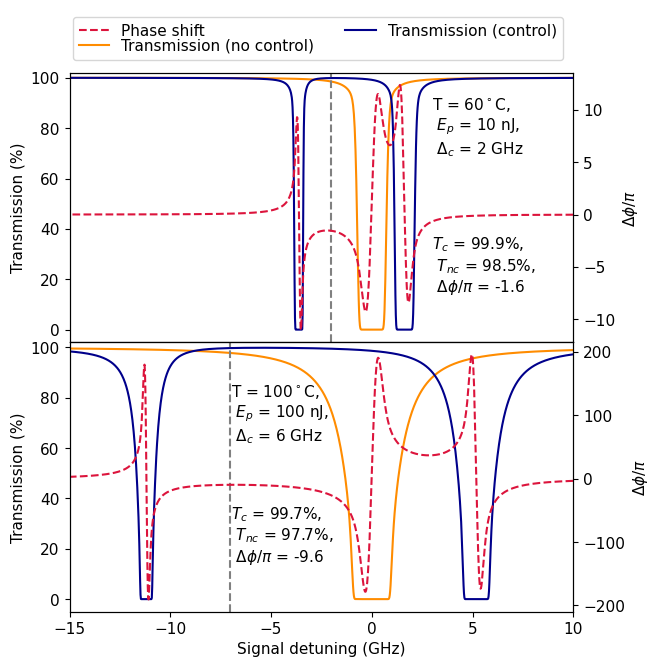

In [7]:
# For Rb87 isotopically pure cells, looking at the upper Rb87 ground state 

#making subplots for different parameters

#Constants
e = 1.602*10**-19 #elementary charge in coulombs .
a0 = 5.29*10**-11 #bohr radius in meters .
c = 2.998*10**8 #speed of light in vacuum .
epsilon0 = 8.854*10**-12 #Vacuum permittivity .
u0 = 1.2566*10**-6 #Vacuum permeability .
kb = 1.381*10**-23 #Boltzmann's constant .
vs = 1 #polarisation vector, assume that d12.vs = d12 
vc = 1 #polarisation vector, assume that d23.vc = d23 
hbar = 1.0546*10**-34 #in SI units .

temperature = [(70+273.15),(90+273.15)]

DeltaPhiArray = []
RatioOfOutputToInputPowerNoControlArray = []
RatioOfOutputToInputPowerControlArray = []


Rb87zeemanWeightingF2 = 5/8
Rb87zeemanWeightingF1 = 0

Rb85zeemanWeightingF3 = 0
Rb85zeemanWeightingF2 = 0

Array = [(60+273.15,10*10**-3,2*np.pi*(2)*10**9),(100+273.15,100*10**-3,2*np.pi*(6)*10**9)]

for T, AveragePower, DeltaCTopRb87 in Array: 
    print(T)
    print(AveragePower)
    print(DeltaCTopRb87)
    #Peak power gaussian pulse (control)
    tFWHM = 4000*10**-12 #our 1ns base width pulses look around ~600ns FWHM on the 1GHz scope
    RepRate = 1*10**6 #3 MHz repetition rate
    #AveragePower = 10*10**-3#48*10**-3 #3*10**-3 #20mW power as control goes up to around 20mW currently
    Epc = AveragePower/RepRate #7*10**-9 #energy of control pulses, probably 100's of pJ to a few nJ  
    Ppeakc = 0.94*Epc/tFWHM 
    #print(Epc, 'This is the pulse energy in Joules')

    w0 = 125*10**-6 #if we use 2.00mm collimating lens with 100mm focusing lenses then we can get a beam waist of around 125um
    #w0 = 450*10**-6 #beam waist (radius), using the 4.51 mm collimating lenses

    #Ipeakc = 2*Ppeakc/(np.pi*w0**2)  #Peak intensity. The peak power I0 = 2*Iavg Assume uniform in x and y, with time dependence on power/intensity Ppeak/A  https://courses.lumenlearning.com/physics/chapter/24-4-energy-in-electromagnetic-waves/
    Ipeakc = Ppeakc/(np.pi*w0**2)  #Average intensity. The peak power I0 = 2*Iavg Assume uniform in x and y, with time dependence on power/intensity Ppeak/A  https://courses.lumenlearning.com/physics/chapter/24-4-energy-in-electromagnetic-waves/
    Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
    Ec = Epeakc
    
    #Relative positions of the ground hyperfine states, relative to the lowest energy Rb87 ground state 
    TopRb87 = 0 #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb87 state
    BottomRb87 = -4.271-2.563 #detuning from the bottom Rb87 hyperfine state (GHz) for the bottom Rb87 state
    TopRb85 = 4.271+1.264 -(4.271+2.563) #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb85 state
    BottomRb85 = 4.271-1.770 -(4.271+2.563) #detuning from the bottom Rb87 hyperfine state (GHz) for the bottom Rb85 state

    #More constants and calculated values 
    f = c/(7800.268*10**-10) #frequency of signal 
    w21 = 2*np.pi*(c/(7800.268*10**-10)) #angular frequency of transition from atomic ground state to intermediate
    w32 = 2*np.pi*(c/(7757.6507*10**-10)) #angular frequency of transition from atomic intermediate state to excited state 

    #swapping top and bottom Rb87 
    
    DeltaSTopRb87 = np.linspace(-2*np.pi*10*10**9, 2*np.pi*15*10**9, 1250)  #the shift is negative, as the shift is too a shorter frequency than w21, delta = w21 - ws, if w21 is the transition from the bottom energy level, then a negative delta is a larger frequency, and a positive detuning is for a smaller frequency  
    DeltaSBottomRb87 = -2*np.pi*BottomRb87*10**9 + DeltaSTopRb87 #np.linspace(-2*np.pi*10*10**9, 2*np.pi*15.0*10**9, 1000) #= w21 - ws what units and sign? Check definition in notes 
    DeltaSTopRb85 = -2*np.pi*TopRb85*10**9 + DeltaSTopRb87
    DeltaSBottomRb85 = -2*np.pi*BottomRb85*10**9 + DeltaSTopRb87

    #DeltaCTopRb87 = 2*np.pi*(3)*10**9 
    #positive value of detuning in the bracket for positive control detuning
    #i.e. blue detuned, longer frequency control to give two photon resonance
    #at a shorter frequency

    DeltaCBottomRb87  = DeltaCTopRb87 ##= w32 - wc what units and sign? Check definition in notes 
    DeltaCTopRb85 =  DeltaCTopRb87 #
    DeltaCBottomRb85 = DeltaCTopRb87 #
    #The control detuning should the same for each Rb ground state as it is the frequency between the middle and upper states
    #and not between the ground and intermediate states! 

    wsBottomRb87 = w21 - DeltaSBottomRb87 #angular frequency of signal field 
    wsTopRb87 = w21 - DeltaSTopRb87 #angular frequency of signal field 
    wsTopRb85 = w21 - DeltaSTopRb85 #angular frequency of signal field 
    wsBottomRb85 = w21 - DeltaSBottomRb85 #angular frequency of signal field 

    wcBottomRb87 = w32 - DeltaCBottomRb87 #angular frequency of control field 
    wcTopRb87 = w32 - DeltaCTopRb87 #angular frequency of control field 
    wcTopRb85 = w32 - DeltaCTopRb85 #angular frequency of control field 
    wcBottomRb85 = w32 - DeltaCBottomRb85 #angular frequency of control field 
    ksBottomRb87 = ks = wsBottomRb87/c #=omega/c
    ksTopRb87 = wsTopRb87/c
    ksTopRb85 = wsTopRb85/c
    ksBottomRb85 = wsBottomRb85/c

    kcBottomRb87 = wcBottomRb87/c #=omega/c
    kcTopRb87 = wcTopRb87/c #=omega/c
    kcTopRb85 = wcTopRb85/c #=omega/c
    kcBottomRb85 = wcBottomRb85/c #=omega/c
    tau2 = 26.24*10**-9 #lifetime of 5P state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
    tau3 = 238.5*10**-9 #lifetime of 5D state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
    gamma2 = 1/tau2
    gamma3 = 1/tau3
    d12 = 4.227*e*a0 #Dipole matrix element for 5S1/2 to 5P3/2 value from Engineering photon-photon interaction within rubidium filled waveguides
    d23 = 0.991*e*a0 #Dipole matrix element for 5P3/2 to 5D5/2 value from Engineering photon-photon interaction within rubidium filled waveguides
    kappa = d12*vs/hbar #similar to the rabi frequency of the signal field, but divided by Es 
    Omega = d23*vc*Ec/hbar #rabi frequency of the control field
    
    lambda0 = c/(w21/(2*np.pi)) #assuming a constant lambda0, we may need to change this so that lambda0 changes as we scan detuning 

    L = 70*10**-3 #length of vapour cell, 7cm (70mm)

    mw = 86.909 #molecular weightmass of Rb atom, either 86.909*u or 86.909 grams per mole 
    u = 1.661*10**-27 #unified atomic mass unit (dalton)
    m = u*mw #mass of a single atom of Rb87 (can either divide molecular weight by Avogadro's number or multiply by universal mass unit to get the weight of an atom. Universal mass unit will get an answer in kg, Avogadro's will get an answer in grams)

    #4*10**-6 Torr at 52 degrees C steck data

    #Calculating the number density for Rb87
    Pv = 10**(15.88253 - 4529.635/T + 0.00058663*T - 2.99138*np.log10(T))  #vapour pressure in Torr
    p87 = Pv*133.322 #Pressure in Pa from Daniel Steck's Rb87 data, assuming only natural abundance of Rb87
    nd87 =  p87/(kb*T) #(atoms per unit volume - relates to vapour pressure of Rb - #probably check steck and choose an isotope )
    #nd87 = 2.95*10**18 #number density at 92.6C estimated from equation in Steck
    #looks like everything above this is correct 

    ARb87 = -nd87*d12*kappa/epsilon0 

    #Defining functions, solving the integration 

    DeltaS = DeltaSTopRb87 

    #maxwell boltzmann distribution in 1D is correct 

    p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function for doppler
    #tauBottomRb87 = lambda v: 1j*gamma2/2 -DeltaS + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-DeltaS)+v*(ks-kcBottomRb87)))
    tauBottomRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*BottomRb87*10**9) + v*ksBottomRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-(DeltaS - 2*np.pi*BottomRb87*10**9))+v*(ksBottomRb87-kcBottomRb87)))
    tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*TopRb87*10**9) + v*ksTopRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCTopRb87-(DeltaS - 2*np.pi*TopRb87*10**9))+v*(ksTopRb87-kcTopRb87)))

    fReBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).real   #A*(row/tau)
    fImBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).imag   #A*(row/tau)

    fReTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
    fImTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)

    ChiReBottomRb87 = quad_vec(fReBottomRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
    ChiImBottomRb87 = quad_vec(fImBottomRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

    ChiReTopRb87 = quad_vec(fReTopRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
    ChiImTopRb87 = quad_vec(fImTopRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

    ChiTotalControl = (ChiReBottomRb87 + ChiReTopRb87) + 1j*(ChiImBottomRb87 +ChiImTopRb87) #complex susceptibility 
    nComplexControl = (1+ChiTotalControl)**0.5 #the complex refractive index with the control field on 

    refractiveIndexControl = nComplexControl.real
    ExtinctionCoefficientControl = nComplexControl.imag

    Ec = 0
    Omega = d23*vc*Ec/hbar #rabi frequency of the control field

    p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function 
    #tauBottomRb87 = lambda v: 1j*gamma2/2 -DeltaS + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-DeltaS)+v*(ks-kcBottomRb87)))
    tauBottomRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*BottomRb87*10**9) + v*ksBottomRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCBottomRb87-(DeltaS - 2*np.pi*BottomRb87*10**9))+v*(ksBottomRb87-kcBottomRb87)))
    tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*TopRb87*10**9) + v*ksTopRb87 -(Omega**2/(1j*gamma3/2 +(DeltaCTopRb87-(DeltaS - 2*np.pi*TopRb87*10**9))+v*(ksTopRb87-kcTopRb87)))

    #the tau equations look correct

    fReBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).real   #A*(row/tau)
    fImBottomRb87 = lambda v: Rb87zeemanWeightingF1*((ARb87)*(p(v))/(tauBottomRb87(v))).imag   #A*(row/tau)

    fReTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
    fImTopRb87 = lambda v: Rb87zeemanWeightingF2*((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)

    ChiReBottomRb87 = quad_vec(fReBottomRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
    ChiImBottomRb87 = quad_vec(fImBottomRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

    ChiReTopRb87 = quad_vec(fReTopRb87, -1000, +1000)[0]  #quad_vec can take a vector and integrate it, i.e. takes an array of values instead of just 1 value, and can output an array of values from integration
    ChiImTopRb87 = quad_vec(fImTopRb87, -1000, +1000)[0]  #only take the first element in each case as the 2nd element is the error, 2nd and 3rd arguments are the limits of v 

    ChiTotalNoControl = (ChiReBottomRb87 + ChiReTopRb87) + 1j*(ChiImBottomRb87 +ChiImTopRb87) #complex susceptibility 
    nComplexNoControl = (1+ChiTotalNoControl)**0.5 #the complex refractive index with the control field on 

    refractiveIndexNoControl = nComplexNoControl.real
    ExtinctionCoefficientNoControl = nComplexNoControl.imag

    DeltaPhi = (refractiveIndexControl - refractiveIndexNoControl)*(2*np.pi*L/lambda0)
    
    f = c/(7800.268*10**-10) #frequency of signal 

    AbsorptionCoefficientNoControl = 4*np.pi*f*ExtinctionCoefficientNoControl/c #absorption coefficient with no control field
    AbsorptionCoefficientControl = 4*np.pi*f*ExtinctionCoefficientControl/c #absorption coefficient with control field

    RatioOfOutputToInputPowerNoControl = np.exp(-AbsorptionCoefficientNoControl*L)
    RatioOfOutputToInputPowerControl = np.exp(-AbsorptionCoefficientControl*L)
    
    DeltaPhiArray.append(DeltaPhi)
    RatioOfOutputToInputPowerNoControlArray.append(RatioOfOutputToInputPowerNoControl)
    RatioOfOutputToInputPowerControlArray.append(RatioOfOutputToInputPowerControl)
    
    #print(DeltaPhiArray)
    #print(DeltaPhi)

#print(DeltaPhiArray)
#print(DeltaPhiArray[0],)
    
    
fig, ax = plt.subplots(2,sharey=False)

#fig, ax = plt.subplots(2, figsize=(8,11),sharey=True)
#plt.figure(figsize=(8,5), dpi=300)
#ax2 = ax1.twinx()

ax0 = ax[0].twinx()


PhaseShift, = ax0.plot(-DeltaSTopRb87*10**-9/(2*np.pi), DeltaPhiArray[0]/(np.pi), '--', color='crimson', label='Phase shift')
TNoControl, = ax[0].plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerNoControlArray[0]*100 , color='darkorange', label='Extinction coefficient (no control field)')
tContorl, = ax[0].plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerControlArray[0]*100 , color='darkblue', label='Extinction coefficient (control field)')

ax1 = ax[1].twinx()

ax1.plot(-DeltaSTopRb87*10**-9/(2*np.pi), DeltaPhiArray[1]/(np.pi), '--', color='crimson', label='Relative phase change')
ax[1].plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerNoControlArray[1]*100 , color='darkorange', label='Extinction coefficient (no control field)')
ax[1].plot(-DeltaSTopRb87*10**-9/(2*np.pi), RatioOfOutputToInputPowerControlArray[1]*100 , color='darkblue', label='Extinction coefficient (control field)')


#plt.axvline(x=-BottomRb87) #assume that we are on resonance with the bottom Rb87 state at -4.271GHz detuning 
#plt.axvline(x=-TopRb87)
#plt.axvline(x=-TopRb85)
#plt.axvline(x=-BottomRb85)

ax[0].set_xlabel('Signal detuning (GHz)')
ax[0].set_ylabel('Transmission (%)')
ax1.set_ylabel('$\Delta \phi$/$\pi$')

ax[1].set_xlabel('Signal detuning (GHz)')
ax[1].set_ylabel('Transmission (%)')
ax0.set_ylabel('$\Delta \phi$/$\pi$')

#ax1.set_ylim(-20, 20)
ax[0].set_ylim(-5, 102)
ax[1].set_ylim(-5, 102)

ax[0].set_xlim(-15, 10)
ax[1].set_xlim(-15, 10)

ax[0].axes.get_xaxis().set_visible(False)

#ax[0].set_ylim(-10, 0)
#ax[1].set_ylim(-20, 0)

plt.figlegend([PhaseShift, TNoControl,tContorl], ['Phase shift', 'Transmission (no control)', 'Transmission (control)'], loc = (0.11, 0.91), ncol=2, labelspacing=0.)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(7) #sets the size of the subplot figure
fig.set_figwidth(6.5)

fig.subplots_adjust(hspace=0)

ax[0].text(3,70,'T = 60$^\circ$C, \n $E_p$ = 10 nJ, \n $\Delta_c$ = 2 GHz',rotation=0) 
ax[1].text(-7,63,'T = 100$^\circ$C, \n $E_p$ = 100 nJ, \n $\Delta_c$ = 6 GHz',rotation=0)

ax[0].tick_params(axis="x",direction="in", pad=-25)


ax[0].text(3,15,'$T_c$ = 99.9%, \n $T_{nc}$ = 98.5%, \n $\Delta \phi$/$\pi$ = -1.6',rotation=0) 
ax[1].text(-7,15,'$T_c$ = 99.7%, \n $T_{nc}$ = 97.7%, \n $\Delta \phi$/$\pi$ = -9.6',rotation=0)

Index1 = 600
xvalue1 = -DeltaSTopRb87[Index1]*10**-9/(2*np.pi)

Index2 = 850
xvalue2 = -DeltaSTopRb87[Index2]*10**-9/(2*np.pi)

ax[0].axvline(xvalue1, color='gray', linestyle='--')
ax[1].axvline(xvalue2, color='gray', linestyle='--')

plt.savefig('phase shift extinction low and high parameters comparison 125um beam waist 4ns.png', dpi=400, bbox_inches='tight')
plt.savefig('phase shift extinction low and high parameters comparison 125um beam waist 4ns.pdf', dpi=400, bbox_inches='tight')

#print(nd87, 'number density')

#1000 points in a scan, 20 GHz scan, so point 650 is the point for -3 GHz as the detuning is plotted backwards... 

print(RatioOfOutputToInputPowerControlArray[0][600],'RatioOfOutputToInputPowerControlArray top plot at -2 GHz')
print(RatioOfOutputToInputPowerNoControlArray[0][600],'RatioOfOutputToInputPowerNoControlArray top plot at -2 GHz')
print(DeltaPhiArray[0][600]/(np.pi),'DeltaPhiArray top plot at -2 GHz')

print(RatioOfOutputToInputPowerControlArray[1][850],'RatioOfOutputToInputPowerControlArray bottom plot at -7 GHz')
print(RatioOfOutputToInputPowerNoControlArray[1][850],'RatioOfOutputToInputPowerNoControlArray bottom plot at -7 GHz')
print(DeltaPhiArray[1][850]/(np.pi),'DeltaPhiArray bottom plot at -7 GHz')

4.7e-08 This is the pulse energy in Joules
0.9789732053628027 RatioControlOnToOff


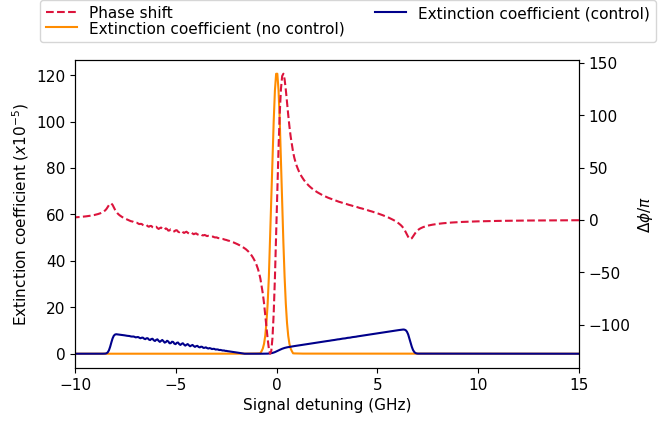

In [9]:
from multiprocessing import Pool, TimeoutError

#Let's try summing over the radial control intensity distribution, which we then weight by the signal distribution 
#as what we observe depends on both the control and signal field distributions 

#Let's assume that the gaussian beam is perfectly collimated, and so the intensity does not depend on z, and only on r
#because we have matched the rayleigh range to the length of our cell, the intensity should not change very much in z
#and so this should be a good assumption to use
#ofcourse for a fibre this would always be the case anyway 

#we can then put the r dependent terms into the loop, set f = 0 and change the loop to a loop over r...

#use equations for a gaussian beam distribution and to work out I0 https://en.wikipedia.org/wiki/Gaussian_beam

#For Rb87 isotopically pure cells
#AveragePower = 47*10**-3#48*10**-3 #3*10**-3 #20mW power as control goes up to around 20mW currently
#DeltaCTopRb87 = 2*np.pi*(1.6)*10**9 
#T = (95+273.15) #Temperature in Kelvin from Daniel Steck's Rb87 data

#Constants
e = 1.602*10**-19 #elementary charge in coulombs .
a0 = 5.29*10**-11 #bohr radius in meters .
c = 2.998*10**8 #speed of light in vacuum .
epsilon0 = 8.854*10**-12 #Vacuum permittivity .
u0 = 1.2566*10**-6 #Vacuum permeability .
kb = 1.381*10**-23 #Boltzmann's constant .
vs = 1 #polarisation vector, assume that d12.vs = d12 
vc = 1 #polarisation vector, assume that d23.vc = d23 
hbar = 1.0546*10**-34 #in SI units .

#Peak power gaussian pulse (control)
tFWHM = 4000*10**-12 #our 1ns base width pulses look around ~600ns FWHM on the 1GHz scope
RepRate = 1*10**6 #3 MHz repetition rate
AveragePower = 47*10**-3 # 10*10**-3 #48*10**-3#3*10**-3 #20mW power as control goes up to around 20mW currently
Epc = AveragePower/RepRate #7*10**-9 #energy of control pulses, probably 100's of pJ to a few nJ  
Ppeakc = 0.94*Epc/tFWHM 
print(Epc, 'This is the pulse energy in Joules')

w0 = 125*10**-6 #if we use 2.00mm collimating lens with 100mm focusing lenses then we can get a beam waist of around 125um
#w0 = 450*10**-6 #beam waist (radius), using the 4.51 mm collimating lenses

#we now make TopRb87 into an array of the two Rb87 detunings
#TopRb87 = [0, -4.271-2.563] #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb87 state
TopRb87 = [0] #detuning from the bottom Rb87 hyperfine state (GHz) for the top Rb87 state

#More constants and calculated values 
f = c/(7800.268*10**-10) #frequency of signal 
w21 = 2*np.pi*(c/(7800.268*10**-10)) #angular frequency of transition from atomic ground state to intermediate
w32 = 2*np.pi*(c/(7757.6507*10**-10)) #angular frequency of transition from atomic intermediate state to excited state 

DeltaSTopRb87 = np.linspace(-2*np.pi*10*10**9, 2*np.pi*10*10**9, 1000)  #the shift is negative, as the shift is too a shorter frequency than w21, delta = w21 - ws, if w21 is the transition from the bottom energy level, then a negative delta is a larger frequency, and a positive detuning is for a smaller frequency  
ControlDetuningGHz = 1.6 #control detuning in GHz

#positive value of detuning in the bracket for positive control detuning
#i.e. blue detuned, longer frequency control to give two photon resonance
#at a shorter frequency


tau2 = 26.24*10**-9 #lifetime of 5P state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
tau3 = 238.5*10**-9 #lifetime of 5D state - value from Engineering photon-photon interaction within rubidium filled waveguides in seconds
gamma2 = 1/tau2
gamma3 = 1/tau3
d12 = 4.227*e*a0 #Dipole matrix element for 5S1/2 to 5P3/2 value from Engineering photon-photon interaction within rubidium filled waveguides
d23 = 0.991*e*a0 #Dipole matrix element for 5P3/2 to 5D5/2 value from Engineering photon-photon interaction within rubidium filled waveguides
kappa = d12*vs/hbar #similar to the rabi frequency of the signal field, but divided by Es 
#Omega = d23*vc*Ec/hbar #rabi frequency of the control field (in angular frequency units)

#lambda0 = lambda ws: c/(ws/(2*np.pi)) #lambda = c/f, f = w/2*pi

lambda0 = c/(w21/(2*np.pi)) #assuming a constant lambda0, we may need to change this so that lambda0 changes as we scan detuning 

L = 70*10**-3 #length of vapour cell, 7cm (70mm)

#Calculating the number density for Rb87
T = (95+273.15) #Temperature in Kelvin from Daniel Steck's Rb87 data
#p87 = 1*4*10**-6*133.322 #66.7*10**-7 #Pressure in Pa from Daniel Steck's Rb87 data, assuming only natural abundance of Rb87
Pv = 10**(15.88253 - 4529.635/T + 0.00058663*T - 2.99138*np.log10(T))  #vapour pressure in Torr
p87 = Pv*133.322 #Pressure in Pa from Daniel Steck's Rb87 data, assuming only natural abundance of Rb87

Rb87zeemanWeightingF2 = 5/8

nd87 =  Rb87zeemanWeightingF2*p87/(kb*T) #(atoms per unit volume - relates to vapour pressure of Rb - #probably check steck and choose an isotope )
#nd87 = 2.95*10**18 #number density at 92.6C estimated from equation in Steck
mw = 86.909 #molecular weightmass of Rb atom, either 86.909*u or 86.909 grams per mole 
u = 1.661*10**-27 #unified atomic mass unit (dalton)
m = u*mw #mass of a single atom of Rb87 (can either divide molecular weight by Avogadro's number or multiply by universal mass unit to get the weight of an atom. Universal mass unit will get an answer in kg, Avogadro's will get an answer in grams)


ARb87 = -nd87*d12*kappa/epsilon0 

#Defining functions, solving the integration 

DeltaS = DeltaSTopRb87 

ChiTotalControlArray = []

NumberOfRadii = 50
StartPointr = 0
EndPointr = 2*w0
RadiusOfControl = np.linspace(StartPointr, EndPointr, NumberOfRadii) #radii to plot

P0 = Ppeakc
I0 = (2*P0)/(np.pi*w0**2)

Deltar = (EndPointr - StartPointr)/NumberOfRadii #width of radius bin  

DeltaS = np.linspace(-2*np.pi*15*10**9, 2*np.pi*15*10**9, 500) 

DeltaC = 2*np.pi*(ControlDetuningGHz)*10**9 

ws = w21 - DeltaS #angular frequency of signal field 
wc = w32 - DeltaC #angular frequency of control field 
kc = wc/c #=omega/c
ks = ws/c #=omega/c

#positive value of detuning in the bracket for positive control detuning
#i.e. blue detuned, longer frequency control to give two photon resonance
#at a shorter frequency

#Calculating susceptibility with control

def ChiReTopRb87(RbState,r,DeltaS):   
            Ipeakc = I0*np.exp((-2*r**2)/(w0**2))  #intensity at a given radius
            Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
            Ec = Epeakc
            Omega = d23*vc*Ec/hbar
            p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function 
            tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*RbState*10**9) + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaC-(DeltaS - 2*np.pi*RbState*10**9))+v*(ks-kc)))
            fReTopRb87 = lambda v: ((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
            return quad_vec(fReTopRb87, -600, +600)[0]
        
def ChiImTopRb87(RbState,r,DeltaS):  
            Ipeakc = I0*np.exp((-2*r**2)/(w0**2))  #intensity at a given radius
            Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
            Ec = Epeakc
            Omega = d23*vc*Ec/hbar
            p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function 
            tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*RbState*10**9) + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaC-(DeltaS - 2*np.pi*RbState*10**9))+v*(ks-kc)))
            fImTopRb87 = lambda v: ((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)
            return quad_vec(fImTopRb87, -600, +600)[0]       

#loop susceptibility functions over r         
        
for RbState in TopRb87:
    for r in RadiusOfControl: 
        ChiReTopRb87(RbState,r,DeltaS)
        ChiImTopRb87(RbState,r,DeltaS)
        #ChiTotalControl = r*((ChiReTopRb87(RbState,r,DeltaS)) + 1j*(ChiImTopRb87(RbState,r,DeltaS)))*((2)/(np.pi*w0**2))*np.exp((-2*r**2)/(w0**2))
        ChiTotalControl = r*((ChiReTopRb87(RbState,r,DeltaS)) + 1j*(ChiImTopRb87(RbState,r,DeltaS)))*((2)/(np.pi*w0**2))*np.exp((-2*r**2)/(w0**2))
        ChiTotalControlArray.append(ChiTotalControl)            

ChiTotalControlArrayStacked = np.vstack(ChiTotalControlArray)
ChiTotalControlArrayStackedSum = 2*np.pi*Deltar*ChiTotalControlArrayStacked.sum(axis=0)

nComplexControl = (1+ChiTotalControlArrayStackedSum)**0.5 #the complex refractive index with the control field on 
refractiveIndexControl = nComplexControl.real
ExtinctionCoefficientControl = nComplexControl.imag 

#Calculating susceptibility with no control

ChiTotalNoControlArray = []

def ChiReTopRb872(RbState,r,DeltaS):  
            Ipeakc = 0 ##intensity at a given radius
            Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
            Ec = Epeakc
            Omega = d23*vc*Ec/hbar #Rabi frequency 
            p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function for boltzmann distribution
            tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*RbState*10**9) + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaC-(DeltaS - 2*np.pi*RbState*10**9))+v*(ks-kc)))
            fReTopRb87 = lambda v: ((ARb87)*(p(v))/(tauTopRb87(v))).real   #A*(row/tau)
            return quad_vec(fReTopRb87, -600, +600)[0]
        
def ChiImTopRb872(RbState,r,DeltaS):  
            Ipeakc = 0 #intensity at a given radius
            Epeakc = ((Ipeakc*2)/(c*epsilon0))**0.5  #The peak electric field strength 
            Ec = Epeakc
            Omega = d23*vc*Ec/hbar
            p = lambda v:(m/(2*np.pi*kb*T))**0.5*np.exp((-m*v**2)/(2*kb*T))  #defining an anonomous function for boltzmann distribution
            tauTopRb87 = lambda v: 1j*gamma2/2 -(DeltaS - 2*np.pi*RbState*10**9) + v*ks -(Omega**2/(1j*gamma3/2 +(DeltaC-(DeltaS - 2*np.pi*RbState*10**9))+v*(ks-kc)))
            fImTopRb87 = lambda v: ((ARb87)*(p(v))/(tauTopRb87(v))).imag   #A*(row/tau)
            return quad_vec(fImTopRb87, -600, +600)[0]       
               
for RbState in TopRb87:
    r = 0
    ChiReTopRb872(RbState,r,DeltaS)
    ChiImTopRb872(RbState,r,DeltaS)
    ChiTotalNoControl = (ChiReTopRb872(RbState,r,DeltaS)) + 1j*(ChiImTopRb872(RbState,r,DeltaS))
    ChiTotalNoControlArray.append(ChiTotalNoControl)            

    
ChiTotalNoControlArrayStacked = np.vstack(ChiTotalNoControlArray)
ChiTotalNoControlArrayStackedSum = ChiTotalNoControlArrayStacked.sum(axis=0)

nComplexNoControl = (1+ChiTotalNoControlArrayStackedSum)**0.5 #the complex refractive index with the control field on 
refractiveIndexNoControl = nComplexNoControl.real
ExtinctionCoefficientNoControl = nComplexNoControl.imag 

DeltaPhi = (refractiveIndexControl - refractiveIndexNoControl)*(2*np.pi*L/lambda0)

#Plotting the phase shift and extinction coefficient 

fig, ax1 = plt.subplots()
#plt.figure(figsize=(8,5), dpi=300)
ax2 = ax1.twinx()

PhaseShift, = ax2.plot(-DeltaS*10**-9/(2*np.pi), DeltaPhi/(np.pi), '--', color='crimson', label='Relative phase change')
TNoControl, = ax1.plot(-DeltaS*10**-9/(2*np.pi), ExtinctionCoefficientNoControl*10**5 , color='darkorange', label='Extinction coefficient (no control field)')
tControl, = ax1.plot(-DeltaS*10**-9/(2*np.pi), ExtinctionCoefficientControl*10**5 , color='darkblue', label='Extinction coefficient (control field)')

ax1.set_xlabel('Signal detuning (GHz)')
ax2.set_ylabel('$\Delta \phi$/$\pi$')
ax1.set_ylabel('Extinction coefficient ($x10^{-5}$)')
ax1.set_xlim(-10, 15)

#ax1.set_ylim(-20, 20)
#ax1.set_xlim(-5, 7.5)

plt.figlegend([PhaseShift, TNoControl,tControl], ['Phase shift', 'Extinction coefficient (no control)', 'Extinction coefficient (control)'], loc = (0.06, 0.90), ncol=2, labelspacing=0.)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

fig.set_figheight(4) #sets the size of the subplot figure
fig.set_figwidth(6.5)

plt.savefig('Phase shift extinction cell 1.6 GHz control detuning pure Rb87 upper state 95C 47nJ pulse 125um beam waist 4ns pulse 500 radii with r and delta r.png', dpi=400, bbox_inches='tight', pad_inches = 0)
plt.savefig('Phase shift extinction cell 1.6 GHz control detuning pure Rb87 upper state 95C 47nJ pulse 125um beam waist 4ns pulse 500 radii with r and delta r.pdf', dpi=400, bbox_inches='tight', pad_inches = 0)

ExtinctionCoefficientSumControlOn = np.sum(ExtinctionCoefficientControl)
ExtinctionCoefficientSumControlOff = np.sum(ExtinctionCoefficientNoControl)
RatioControlOnToOff = ExtinctionCoefficientSumControlOn/ExtinctionCoefficientSumControlOff

print(RatioControlOnToOff, 'RatioControlOnToOff')

#if the extinction coefficient with the control on is properly normalised then the sum of all the extinction coefficient
#values should match as there is the same number of atoms...